> ### EEE4423: Deep Learning Lab

# LAB \#12: Sequence to Sequence Network with Attention Module
## Machine Translation with Attention

<h4><div style="text-align: right"> Due date: May 27, 2022. </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab12.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2017142136] [이관희]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-26 02:09:06.706751


In this project we will be teaching a neural network to translate from
French to English.
*************************************************************
::

    [(>): input, (=): target, (<): output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

...
*************************************************************

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


### 1. Prepare data

The data for this project is a set of many thousands of English to French translation pairs. Download the data from <https://download.pytorch.org/tutorial/data.zip>. The file is a tab separated list of translation pairs:


    I am cold.    J'ai froid.
    
<img src="https://drive.google.com/uc?export=view&id=1K3W2RxeTKih5IiT5PcIyWNZSwMqtYSGZ"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

In [4]:
SOS_token = 0 # 문장의 시작을 의미함
EOS_token = 1 # 문장의 끝을 의미함

# 단어를 index로 변환하는 문제이다.
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words # 그 단어 넣기
            self.word2count[word] = 1 # 몇개가 온지 숫자 세기
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# 일부 문장 만 선택
            
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")
            
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
# 질문 : 무슨 뜻인지 이해가 되지 않습니다. -> 그냥

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip()) # 빈 문자 제거
    s = re.sub(r"([.!?])", r" \1", s) # text_mod = re.sub('apble|abple',"apple",text) 변경
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
# 질문 : 이게 왜 normalize 이지? -> 

def readLangs(lang1, lang2, reverse=False):
    # Read the file and split into lines
    lines = open('../dataset/lab12/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

# 데이터 준비
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        # 질문 : pair[0]를 의미하는 것
        output_lang.addSentence(pair[1])
        # 질문 : pair[1]을 의미하는 것
    print("Counted words:", input_lang.name, '=', input_lang.n_words, output_lang.name, '=', output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counted words: fra = 4345 eng = 2803
['vous etes fort occupee .', 'you re very busy .']


In [5]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 2. Build the Seq2Seq model [5 points]

<img src="https://drive.google.com/uc?export=view&id=1kKXrIIxi0t-Nm5HfzOukqjzEp7yEXEpV"  onerror="this.style.display='none'" /><br><br>

[sequence to sequence network](https://arxiv.org/abs/1409.3215) is a model in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a single vector,
and a decoder network unfolds that vector into a new sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

#### Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.  
<img src="https://drive.google.com/uc?export=view&id=1PyKBEVl5jwQfB0I0P2kG8nTGQVZQdZEM"  onerror="this.style.display='none'" /><br><br>

#### GRU
<img src="https://drive.google.com/uc?export=view&id=1467jVFRYbw1DYvVKeSyzGWLRmtlqpy8z"  onerror="this.style.display='none'" style="width: 700px;"/><br><br>
The GRU operates using a reset gate (r) and an update gate (z). The candidate state is created by using the previous hidden state and the current input. It is the reset gate that determines how the previous hidden state affects the candidate state. The newly created candidate state and the previous hidden state create a new hidden state, in which the update gate plays a role in balancing the two.

#### LSTM vs GRU
<img src="https://drive.google.com/uc?export=view&id=1lzGTsIYvPWKNF-XaTevMaaZvjfgp9G35"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

| <center>LSTM</center> | <center>GRU</center>  |
|:--------|--------|
| LSTM has 3 gates (forget, input, output) | GRU has 2 gates (reset, update) |
| There is an internal memory (cell state) | There is no cell state and only hidden state exists |
| When making output, another non-linearity is applied | There is no additional non-linearity when making output  |

In [6]:
class GRU(nn.Module) :
    def __init__(self, input_dim, hidden_dim):
        super(GRU, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # reset gate
        self.reset_gate_x = nn.Linear(input_dim, hidden_dim)
        self.reset_gate_h = nn.Linear(hidden_dim, hidden_dim)

        #update_gate
        self.update_gate_x = nn.Linear(input_dim, hidden_dim)
        self.update_gate_h = nn.Linear(hidden_dim, hidden_dim)
        
        # h gate
        self.h_gate_x = nn.Linear(input_dim, hidden_dim)
        self.h_gate_h = nn.Linear(hidden_dim, hidden_dim)

        ##output_gate
        self.output_gate_x = nn.Linear(input_dim,hidden_dim)
        self.output_gate_h = nn.Linear(hidden_dim,hidden_dim)

        self.sigmoid = nn.Sigmoid()
        
        self.tanh = nn.Tanh()

        self.decoder = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, x , hn) :
        ## update gate -> z_t
        z_t=self.sigmoid(self.update_gate_x(x)+self.update_gate_h(hn)) # [1,1,100]
        
        ## reset gate -> r_t
        r_t=self.sigmoid(self.reset_gate_x(x)+self.reset_gate_h(hn))      #[1,1,100]  
        tillde_h = self.tanh(self.h_gate_x(x)+self.h_gate_h(hn*r_t)) # [1,1,100]
        
        ## h_t
        h_t = (1-z_t)*tillde_h + z_t*hn
        
        output = self.decoder(h_t.view(1,-1)) # [1,100]
        output = output.unsqueeze(0)
        return output, h_t

In [7]:
# 2 points
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EncoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        ## gru 부분 다시 설계할 필요가 있다. -> module로 구현하자.
#         self.gru = nn.GRU(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim)
    def forward(self, input, hn):
        ##
        # print(input.size()) # torch.Size([1])
        k = self.embedding(input)
        # print(k.size()) # torch.Size([1, 256])
        embedded = self.embedding(input).view(1, 1, -1)
        # print(embedded.size()) # torch.Size([1, 1, 256])
        output, hn = self.gru(embedded, hn)
        # print(output.size()) # torch.Size([1, 1, 256])
#         print(hn.size()) # torch.Size([1, 1, 256])
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        #############
        h0 = torch.zeros(1, 1, self.hidden_dim, device=device)
        return h0
    
hidden_dim = 256
encoder = EncoderRNN(input_lang.n_words, hidden_dim).to(device)

In [8]:
input_lang.n_words

4345

In [9]:
training_pairs = [tensorsFromPair(random.choice(pairs)) for iter in range(5)]

In [10]:
input = training_pairs[4][0]
target = training_pairs[4][1]

In [11]:
input.type()

'torch.cuda.LongTensor'

In [12]:
h = encoder.initHidden()
input_length = input.size(0)
encoder_outputs = torch.zeros(10, encoder.hidden_dim, device=device)

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input[ei], h)
    encoder_outputs[ei] = encoder_output[0,0]
#     break 

In [13]:
encoder_output.size()

torch.Size([1, 1, 256])

In [14]:
encoder_output[0,0].size()

torch.Size([256])

In [15]:
encoder

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(
    (reset_gate_x): Linear(in_features=256, out_features=256, bias=True)
    (reset_gate_h): Linear(in_features=256, out_features=256, bias=True)
    (update_gate_x): Linear(in_features=256, out_features=256, bias=True)
    (update_gate_h): Linear(in_features=256, out_features=256, bias=True)
    (h_gate_x): Linear(in_features=256, out_features=256, bias=True)
    (h_gate_h): Linear(in_features=256, out_features=256, bias=True)
    (output_gate_x): Linear(in_features=256, out_features=256, bias=True)
    (output_gate_h): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
    (tanh): Tanh()
    (decoder): Linear(in_features=256, out_features=256, bias=True)
  )
)

#### Decoder
<img src="https://drive.google.com/uc?export=view&id=1Rm_LlpEolCvPuzPWEFOZ-zdTfsgMbtu-"  onerror="this.style.display='none'" /><br><br>

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence. Attention allows the decoder network to "focus" on a specific part of
the encoder's outputs for every step and thus help the decoder choose the right output words. 

<img src="https://drive.google.com/uc?export=view&id=18hsS8PAA7I3QaN9oOebfnMGAMhR-6EID"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

<img src="https://drive.google.com/uc?export=view&id=1F1Y92uLvGaI6s-ygyNKNox4ZGiZmTZ3g"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

The attention weights are calculated using an another feed-forward layer which inputs the decoder's input and hidden state. And the calculated attention weight is multiplied to the corresponding hidden state of the encoder, respectively. Note that to actually create and train this layer we have to choose a maximum sentence length. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

<img src="https://drive.google.com/uc?export=view&id=1JEE23gtJf4XciJUXLt2R9lZtpRn8mYCN"  onerror="this.style.display='none'" /><br><br>

In [16]:
# 3 points
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_dim, self.hidden_dim)
#         self.embedding = nn.Embedding(1, self.hidden_dim) -> toy example
        self.dropout = nn.Dropout(self.dropout_p)
        
        # attention
        # Note that the column of the attention weights is MAX_LENGTH
        # Note that concatenation is used when "attn" and "attn_combine" are created
        #############
        # attention은 결국 적절한 hidden_dim에 어떤 값을 곱해주는 것이다.
        self.attention = nn.Linear(self.hidden_dim * 2, MAX_LENGTH) # MAX_LENGTH = 10
        self.attention_combine = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        
        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
#         self.gru = nn.GRU(self.hidden_dim, self.hidden_dim)
        self.gru = GRU(self.hidden_dim, self.hidden_dim)

        self.out = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input, hn, encoder_outputs):
        input = self.embedding(input).view(1, 1, -1) # 이렇게 해야 1,1,256 이 됨.
        input = self.dropout(input)
        
        # attention
        # All specifications of the operations are described in the above figure (e.g. use ReLU)
        # bmm is a operation which performs a batch matrix-matrix product
        #############
        embedded = input
#         print(embedded.size()) # torch.Size([1, 1, 256])
        attn_weights = F.softmax(
            self.attention(torch.cat((embedded[0], hn[0]), 1)), dim=1) # 1,512 -> 1,10 
        #
#         print(attention_weights.size()) # torch.Size([1, 10]) toy example
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # print(attn_applied.size()) -> torch.Size([1, 1, 256])
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        attn_combine = self.attention_combine(output).unsqueeze(0) # [1,1,256]
        
        output = F.relu(attn_combine)
        
        # gru
        #############
        output, hidden = self.gru(output, hn)
        #print(output.size()) # torch.Size([1, 256]) -> 내가 만든 GRU
        # print(output.size()) # torch.Size([1, 1, 256]) -> nn.GRU
        output = F.log_softmax(self.out(output[0]), dim=1)
        # print(output.size()) # torch.Size([1, 2803])
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        ############# 없어도 됨
        h0 = torch.zeros(1, 1, self.hidden_dim, device=device)
        return h0
    
decoder = AttnDecoderRNN(hidden_dim, output_lang.n_words, dropout_p=0.1).to(device)

In [17]:
decoder_hidden = encoder_hidden

In [18]:
SOS_TOKEN = 0
decoder_input = torch.tensor([[SOS_TOKEN]], device=device)


In [19]:
output_lang.n_words

2803

In [20]:
embedding = nn.Embedding(1, 256)

In [21]:
decoder_input.size()

torch.Size([1, 1])

In [22]:
decoder_output, decoder_hidden  = decoder(decoder_input, decoder_hidden, encoder_outputs)

### 3. Loss function and optimizer

In [23]:
criterion = nn.NLLLoss()

learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

### 4. Write the evaluation code [2 points]

- Using the trained model, display the translated output given input sentence.

In [24]:
input_lang

In [25]:
def evaluate(sentence):
    with torch.no_grad():
        # tensor을 문장으로 바꾸자.
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #### 값 초기화
        encoder_hidden = encoder.initHidden()
        
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
        
        
        #### encoder의 output을 저장
        for i in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[i],encoder_hidden)
            encoder_outputs[i] += encoder_output[0, 0]
        # 위에처럼 구성하면 encoder의 모든 output을 저장할 수 있다. 
        
        # decoder의 초기값 저장
        decoder_input = torch.tensor([[SOS_token]], device=device)
        
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        
        #############
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # topk는 지정된 차원을 따라 지정된 텐서의 가장 큰 요소를 반환합니다.
            topv, topi = decoder_output.data.topk(1)
            # top value = topv , top index = topi를 의미한다.
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>') # <EOS> 츨력하기 싫으면 이 부분만 주석하면 된다.
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                # decoded_words에 적절한(최대의 확률을 가지는) 단어가 대입 됨. 

            decoder_input = topi.squeeze().detach() # topidex의 값이 단어로써 들어가게된다.

        return decoded_words
    
def evaluateRandomly():
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

In [26]:
evaluateRandomly()


> vous etes celle qui m a formee .
= you re the one who trained me .
< somewhere rent stylish stylish real milk milk milk milk somewhere



### 5 . Write the code to train the model [3 points]

- During training, use the `Teacher forcing` concept in addition to a naive approach.
    - In other words, instead of using the decoder's guess as the next input, the real target outputs are also used sometimes. This shows faster convergence.
- Plot the training loss curve.
- Show the result using $evaluateRandomly()$ function. Below is an example.
*************************************************************
    > il est en train de peindre un tableau . (input)
    = he is painting a picture . (target)
    < he is painting a picture . (output)
*************************************************************

In [97]:
n_iters = 50000
# n_iters = 1000
print_every = 1000
plot_every =100

plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

for iter in range(1, n_iters+1):
    # Load data
    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    
    # Clear gradients w.r.t. parameters
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device) # 10 = MAX_LENGTH
    loss = 0
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Forward pass
    # encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0,0]
    
    # decoder    
    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[SOS_token]], device=device)
            
    is_teacher_forcing = True if random.random() < 0.5 else False # 밑에 두가지 경우를 확률적으로 1/2로 선택한다.
    
    # 여기서는 학습 데이터의 다음 입력을 받기 때문에 decoder이 잘못 예측해도 encoder,decoder 이 잘 학습된다.
    if is_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            # 학습 데이터에서 다음 입력을 선택
            decoder_input = target_tensor[di]
    # 여기서는 decoder의 output으로 학습을 이어가기 때문에 decoder의 output이 잘 맞아야 encoder이 잘 학습된다.
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            # decoder의 출력 값을 다음 입력을 선택 
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() 
            
            if decoder_input.item() == EOS_token: # <EOS>가 나오면 반복문을 끝낸다.
                break
            
    # Backward pass
    loss.backward()
    
    # Updating parameters
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    print_loss_total += loss.item() / target_length
    plot_loss_total += loss.item() / target_length

    if iter % print_every == 0:
        print('*'*25, 'iter%d'%iter, '*'*25)
        print('loss %.4f'%loss)
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        evaluateRandomly()

    if iter % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

************************* iter1000 *************************
loss 36.7561
> je suis desolee de t avoir blesse .
= i m sorry i hurt you .
< i m not . <EOS>

************************* iter2000 *************************
loss 23.8050
> tu es excuse .
= you re forgiven .
< you re very . <EOS>

************************* iter3000 *************************
loss 15.5773
> il est fort en colere .
= he is very angry .
< he s a . <EOS>

************************* iter4000 *************************
loss 10.9581
> je suis content de vous voir ici .
= i m glad to see you here .
< i m glad you you . <EOS>

************************* iter5000 *************************
loss 11.1328
> il est normalement chez lui le soir .
= he is generally at home in the evening .
< he is a to . <EOS>

************************* iter6000 *************************
loss 6.9102
> il est tres comprehensif .
= he s very understanding .
< he is very good . <EOS>

************************* iter7000 *************************
loss 2

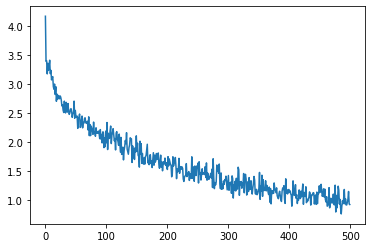

In [98]:
#################################################
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(plot_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)

이 실험 내용은 https://velog.io/@jooh95/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-Attention%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-Seq2Seq%EB%A1%9C-%EA%B8%B0%EA%B3%84%EB%B2%88%EC%97%AD-%EA%B5%AC%ED%98%84
을 주로 참고하였다.

이 실험은 NLP의 기본이 되는 모델인 기계번역에 처음으로 attention을 도입한 논문 NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE을 참고사마 조금 변형된 구조를 구현하는 것이다.
Seq2seq 논문에서 제시한 모델은 input sequence의 정보를 담은 context
vector을 만들 때 fixed length vector라는 한계점이 존재했다. 즉 가변 길이
의 sequence가 들어왔음에도 이를 fixed length vector로 표현했다는 것이
다. 이렇게 되면 sentence의 길이가 길어질수록 성능 저하가 현저히 발생
한다. 이 논문에서는 이 문제를 해결한 새로운 모델을 제시한다. RNN 구조를 따르고 있는데 RNN 구조는 GRU 구조를 사용하였다. 뿐만 아니라 attention 구조를 사용해서 어떤 단어를 보고 예측한 단어를 추출해내는지 결정한다. 


예상했던 점 : GRU는 LSTM에 비해 parameter 갯수가 더 작기 때문에 더 효율적으로 코드 구현이 가능하다. paramter 수가 작은것에 비해 성능은 비슷하다.
    
예상과 달랐던 점 및 개선할 점 : 
이 코드는 전체적으로 기계번역을 위한 함수가 많았기 때문에 아직 정확한 코드들이 이해가 되지 않았다. 예를 들면 normalizeString 같은 코드는 String에서 학습하기 어려운 단어들을 바꿔주는 것 같긴한데 왜 이렇게 구현했는지 이해가 되지 않았다는 점이 아쉽다. 
개선할 점으로는 attention 논문은 forward backward에서 얻은 hidden state를 cat해주는데 여기는 이 과정이 없다. 논문에서는 이 과정에서 문장의 앞만 이아니라 뒤의 단어도 보면서 예측하기 때문에 더 정확하다고 소개하기 때문에 이런 구현을 넣으면 성능이 더 올라갈 것이다.

결론 : GRU를 사용한 기계번역 task에서 사용할 수 있는 모델을 구현해봄으로써 모델의 전체적인 구조를 학습할 수 있었다. 
    
의문점 : 수업시간에 GPT-3와 transformer 를 소개해주셨는데 이해가 되지 않았다. 이 두 모델 모두 long-term dependency 문제를 완벽히 해결한 모델이라고
소개해주셨는데 다음에 기회가 된다면 논문을 읽고 어떤 구현을 사용했는지 알고 싶다.

아래는 bidirectional  을 구현해볼 것이다.

In [39]:
# 3 points
class AttnDecoderRNN_bi(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p=0.1):
        super(AttnDecoderRNN_bi, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_dim, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)

        self.attention = nn.Linear(self.hidden_dim * 3, MAX_LENGTH) # MAX_LENGTH = 10
        self.attention_combine = nn.Linear(self.hidden_dim * 2, self.hidden_dim*2)
        
        self.gru = GRU(self.hidden_dim*2, self.hidden_dim*2)

        self.out = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input, hn, encoder_outputs):
        input = self.embedding(input).view(1, 1, -1) # 이렇게 해야 1,1,256 이 됨.
        input = self.dropout(input)
        
        embedded = input
        attn_weights = F.softmax(
            self.attention(torch.cat((embedded[0], hn[0]), 1)), dim=1) # 1,512 -> 1,10 
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        attn_combine = self.attention_combine(output).unsqueeze(0) # [1,1,256]
        output = F.relu(attn_combine)
        #print(output.size())
        #print(hn.size())
        output, hidden = self.gru(output, hn)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hn

    def initHidden(self):
        h0 = torch.zeros(1, 1, self.hidden_dim, device=device)
        return h0
    

In [40]:
criterion = nn.NLLLoss()
encoder_bilinear_forward = EncoderRNN(input_lang.n_words, hidden_dim).to(device)
encoder_bilinear_backward = EncoderRNN(input_lang.n_words, hidden_dim).to(device)
decoder_bilinear = AttnDecoderRNN(hidden_dim, output_lang.n_words, dropout_p=0.1).to(device)

learning_rate=0.01
encoder_optimizer_for = optim.SGD(encoder_bilinear_forward.parameters(), lr=learning_rate)
encoder_optimizer_back = optim.SGD(encoder_bilinear_backward.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder_bilinear.parameters(), lr=learning_rate)

In [41]:
def evaluate_bi(sentence):
    with torch.no_grad():
        # tensor을 문장으로 바꾸자.
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #### 값 초기화
    
        # Clear gradients w.r.t. parameters
        encoder_hidden_forward = encoder_bilinear_forward.initHidden()
        encoder_hidden_backward = encoder_bilinear_backward.initHidden()
        encoder_outputs_forward = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device) # 10 = MAX_LENGTH
        encoder_outputs_backward = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device) # 10 = MAX_LENGTH

        #### encoder의 output을 저장
        for ei in range(input_length):
            encoder_output_forward, encoder_hidden_forward = encoder_bilinear_forward(input_tensor[ei], encoder_hidden_forward)
            encoder_outputs_forward[ei] = encoder_output_forward[0,0]  
            encoder_output_backward, encoder_hidden_backward = encoder_bilinear_backward(input_tensor[input_length -1 - ei], encoder_hidden_backward)
            encoder_outputs_backward[ei] = encoder_output_backward[0,0]
#         for i in range(input_length):
#             encoder_output, encoder_hidden = encoder_bilinear_forward(input_tensor[i],encoder_hidden)
#             encoder_outputs[i] += encoder_output[0, 0]
        # 위에처럼 구성하면 encoder의 모든 output을 저장할 수 있다. 
        
        # decoder의 초기값 저장
        decoder_input = torch.tensor([[SOS_token]], device=device)
        
        decoder_hidden = encoder_hidden_forward  + encoder_hidden_backward # 1,1,256
        
        decoded_words = []
        
        #############
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder_bilinear(decoder_input, decoder_hidden, encoder_outputs_forward)
            # topk는 지정된 차원을 따라 지정된 텐서의 가장 큰 요소를 반환합니다.
            topv, topi = decoder_output.data.topk(1)
            # top value = topv , top index = topi를 의미한다.
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>') # <EOS> 츨력하기 싫으면 이 부분만 주석하면 된다.
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                # decoded_words에 적절한(최대의 확률을 가지는) 단어가 대입 됨. 

            decoder_input = topi.squeeze().detach() # topidex의 값이 단어로써 들어가게된다.

        return decoded_words
    
def evaluateRandomly_bi():
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words = evaluate_bi(pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

In [42]:
evaluateRandomly()

> tu es bavard .
= you re talkative .
< supposed experienced experienced supposed currently supposed experienced supposed currently supposed



In [43]:
n_iters = 50000
# n_iters = 1000
print_every = 1000
plot_every =100

plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

for iter in range(1, n_iters+1):
    # Load data
    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    
    # Clear gradients w.r.t. parameters
    encoder_hidden_forward = encoder_bilinear_forward.initHidden()
    encoder_hidden_backward = encoder_bilinear_backward.initHidden()
    encoder_optimizer_for.zero_grad()
    encoder_optimizer_back.zero_grad()
    decoder_optimizer.zero_grad()
    encoder_outputs_forward = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device) # 10 = MAX_LENGTH
    encoder_outputs_backward = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device) # 10 = MAX_LENGTH
    loss = 0
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Forward pass
    # encoder
    for ei in range(input_length):
        encoder_output_forward, encoder_hidden_forward = encoder_bilinear_forward(input_tensor[ei], encoder_hidden_forward)
        encoder_outputs_forward[ei] = encoder_output_forward[0,0]  
        encoder_output_backward, encoder_hidden_backward = encoder_bilinear_backward(input_tensor[input_length -1 - ei], encoder_hidden_backward)
        encoder_outputs_backward[ei] = encoder_output_backward[0,0]
    
    # decoder    
    decoder_hidden = encoder_hidden_forward  + encoder_hidden_backward # 1,1,256
    decoder_input = torch.tensor([[SOS_token]], device=device)
    is_teacher_forcing = True if random.random() < 0.5 else False
    if is_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder_bilinear(decoder_input, decoder_hidden, encoder_outputs_forward)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    # 여기서는 decoder의 output으로 학습을 이어가기 때문에 decoder의 output이 잘 맞아야 encoder이 잘 학습된다.
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder_bilinear(decoder_input, decoder_hidden, encoder_outputs_forward)
            loss += criterion(decoder_output, target_tensor[di])
            # decoder의 출력 값을 다음 입력을 선택 
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() 
            
            if decoder_input.item() == EOS_token: # <EOS>가 나오면 반복문을 끝낸다.
                break
            
    # Backward pass
    loss.backward()
    
    # Updating parameters
    encoder_optimizer_for.step()
    encoder_optimizer_back.step()
    decoder_optimizer.step()
    
    print_loss_total += loss.item() / target_length
    plot_loss_total += loss.item() / target_length

    if iter % print_every == 0:
        print('*'*25, 'iter%d'%iter, '*'*25)
        print('loss %.4f'%loss)
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        evaluateRandomly_bi()

    if iter % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

************************* iter1000 *************************
loss 25.9588
> je peux courir .
= i m able to run .
< i m afraid . <EOS>

************************* iter2000 *************************
loss 45.9657
> tu es mon meilleur ami .
= you re my best friend .
< you re very . <EOS>

************************* iter3000 *************************
loss 16.5896
> elle a les pieds en dedans .
= she is pigeon toed .
< she is afraid . <EOS>

************************* iter4000 *************************
loss 17.7468
> nous ne sortons pas ensemble .
= we re not dating .
< we re not a . . . . . .

************************* iter5000 *************************
loss 27.0172
> je vais sortir cet apres midi .
= i m going to go out this afternoon .
< i m going to . <EOS>

************************* iter6000 *************************
loss 14.2431
> je suis pret a retrousser mes manches .
= i m ready to roll up my sleeves .
< i am a to . <EOS>

************************* iter7000 *************************
lo

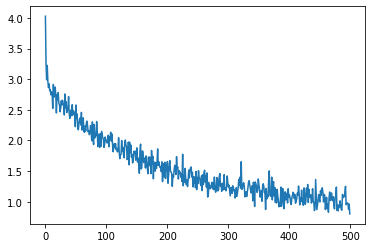

In [44]:
#################################################
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(plot_losses)

결과는 좋은데 bidirectional을 완전하게 구현한게 아닌 것 같아서 정확도는 위의 한방향일 때와 별 차이 없다.